In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), wrong source (2), incompatible header (14), mismatched flags (2))


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [7]:
# Circle: returns true if (px, py) is inside the circle of radius r centered at (cx, cy)
circle_mask(px, py, cx, cy, r) = (px - cx)^2 + (py - cy)^2 <= r^2

# Cross: returns true if (px, py) is within the cross arms centered at (cx, cy) with arm length size and thickness t
function cross_mask(px, py, cx, cy, size, t)
    half = size / 2
    # Horizontal arm
    in_h = abs(py - cy) <= t/2 && abs(px - cx) <= half
    # Vertical arm
    in_v = abs(px - cx) <= t/2 && abs(py - cy) <= half
    return in_h || in_v
end

# Rasterize a random shape to a grid array
function raster_random_shape(rng::AbstractRNG; canvas_size=10, grid_size=128, cross_thickness=0.2)
    shape_type = rand(rng, ["cross", "circle"])
    vmap = Dict("cross" => 1, "circle" => 2)
    x = rand(rng) * canvas_size
    y = rand(rng) * canvas_size
    size = (0.5 + rand(rng)) * (canvas_size / 5)
    t = cross_thickness * size

    # Set up grid coordinates (center of each pixel)
    xs = range(0, canvas_size, length=grid_size)
    ys = range(0, canvas_size, length=grid_size)
    img = zeros(Float32, grid_size, grid_size, 1)

    for j in 1:grid_size, i in 1:grid_size
        px, py = xs[i], ys[j]
        if shape_type == "circle"
            img[j, i, 1] = circle_mask(px, py, x, y, size/2) ? 1 : 0
        else
            img[j, i, 1] = cross_mask(px, py, x, y, size, t) ? 1 : 0
        end
    end
    return img, vmap[shape_type]
end

raster_random_shape (generic function with 1 method)

In [8]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [9]:
args = Args(batchsize = 128, epochs = 25)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [10]:
function generate_dataset(rng::AbstractRNG, n::Int, args::Args)
    data = [raster_random_shape(rng) for i in 1:n];
    x = stack([d[1] for d in data]);
    y = onehotbatch(stack([d[2] for d in data]), 1:2);
    loader = DataLoader((x, y), batchsize = args.batchsize)
    return loader
end

generate_dataset (generic function with 1 method)

In [11]:
train_loader = generate_dataset(rng, 10000, args)

79-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [12]:
x0, y0 = first(train_loader)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 1 1 … 1 1])

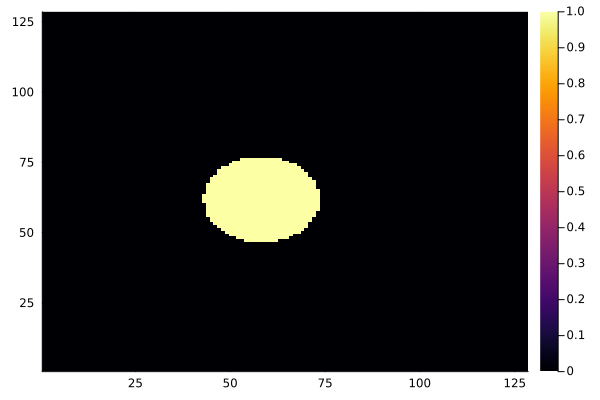

In [13]:
heatmap(x0[:,:,1,1])

In [14]:
y0[:,1]

2-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 1

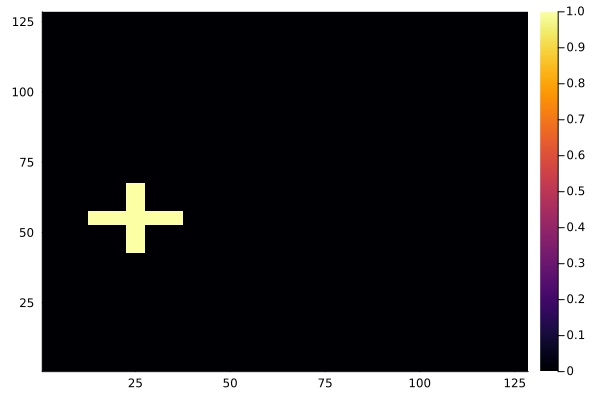

In [15]:
heatmap(x0[:,:,1,5])

In [16]:
y0[:,5]

2-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅

In [17]:
model = Chain(Conv((32,32), 1=>3, relu, pad=(1,1)),
            MaxPool((2,2)),
            Dropout(0.3),

            Conv((16,16), 3=>1, relu, pad=(1,1)),
            MaxPool((2,2)),
            FlattenLayer(),
            Dropout(0.4),

            Dense(324 => 16, relu),
            Dense(16 => 2),
            softmax)

Chain(
    layer_1 = Conv((32, 32), 1 => 3, relu, pad=1),  # 3_075 parameters
    layer_2 = MaxPool((2, 2)),
    layer_3 = Dropout(0.3),
    layer_4 = Conv((16, 16), 3 => 1, relu, pad=1),  # 769 parameters
    layer_5 = MaxPool((2, 2)),
    layer_6 = FlattenLayer{Nothing}(nothing),
    layer_7 = Dropout(0.4),
    layer_8 = Dense(324 => 16, relu),   # 5_200 parameters
    layer_9 = Dense(16 => 2),           # 34 parameters
    layer_10 = WrappedFunction(softmax),
)         # Total: 9_078 parameters,
          #        plus 4 states.

In [ ]:
struct PhasorConv <: LuxCore.AbstractLuxWrapperLayer{:conv}
    conv
end

In [29]:
function PhasorConv(k::Tuple{Vararg{<:Integer}}, chs::Pair{<:Integer,<:Integer}; return_solution::Bool = false, kwargs...)
    #construct the convolutional layer
    conv = Conv(k, chs, identity, kwargs...)
    return PhasorConv(conv)
end

function (pc::PhasorConv)(x, ps, st)
    x = angle_to_complex(x)
    y_real, st_real = pc.conv(real.(x), ps, st)
    y_imag, st_imag = pc.conv(imag.(x), ps, st)
    st = (conv_real = st_real, conv_imag = st_imag)
    y = y_real .+ 1im .* y_imag
    y = complex_to_angle(y)
    
    return x, st
end

In [30]:
pcl = PhasorConv((32, 32), 1 => 3)

PhasorConv(
    conv = Conv((32, 32), 1 => 3),      # 3_075 parameters
)         # Total: 3_075 parameters,
          #        plus 0 states.

In [31]:
pcl.conv

Conv((32, 32), 1 => 3)  # 3_075 parameters

In [32]:
m1 = Chain(PhasorConv((32, 32), 1 => 3),)

Chain(
    layer_1 = PhasorConv(
        conv = Conv((32, 32), 1 => 3),  # 3_075 parameters
    ),
)         # Total: 3_075 parameters,
          #        plus 0 states.

In [40]:
psp, stp = Lux.setup(rng, m1) .|> gdev

((layer_1 = (weight = Float32[0.035673477 0.030589912 … 0.009955608 -0.0067071905; 0.030340392 -0.052724507 … 0.009805409 -0.003190011; … ; 0.037927207 -0.040962927 … 0.033371802 0.048834637; 0.037906285 0.011881138 … 0.0049697547 -0.003527013;;;; 0.046922285 0.013501714 … 0.040111545 -0.022665305; -0.028477296 -0.03027592 … 0.030685924 0.009053828; … ; -0.021658951 0.019813133 … -0.0008969599 0.038606938; -0.02643712 0.044079103 … 0.045389023 -0.030729253;;;; -0.04109729 0.006353677 … 0.042279627 0.0170175; 0.045661803 0.02481048 … 0.043956093 -0.04562935; … ; -0.011410371 0.04625101 … 0.019335372 -0.04763259; -0.025008684 -0.015938448 … -0.012306383 0.030728748], bias = Float32[0.025889784, 0.009410448, 0.014035977]),), (layer_1 = NamedTuple(),))

In [41]:
m1(x0 |> gdev, psp, stp)

(ComplexF32[1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im; … ; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im;;;; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im; … ; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im;;;; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im; … ; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im;;;; … ;;;; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im; 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im … 1.0f0 + 0.0f0im 1.0f0 + 0.0f0im; … ; 1.0f0 + 0.0f0im 1.

In [ ]:
st.layer

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (rng = Xoshiro(0xac2a382c00c02a07, 0xa4fc9372a5dc2eb6, 0x34e526104a42f6b5, 0x4c6c2d1829434272, 0xc90c4a0730db3f7e), training = Val{true}()), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple(), layer_7 = (rng = Xoshiro(0x44ba86468c5f46c3, 0x3c338d4eef5ef204, 0xbe2a558417eedcb2, 0xed989d1217cd5193, 0xc90c4a0730db3f7e), training = Val{true}()), layer_8 = NamedTuple(), layer_9 = NamedTuple(), layer_10 = NamedTuple())

In [ ]:
p_model = Chain(Conv((32,32), 1=>3, relu, pad=(1,1)),
            MaxPool((2,2)),
            Dropout(0.3),

            Conv((16,16), 3=>1, relu, pad=(1,1)),
            MaxPool((2,2)),
            FlattenLayer(),
            Dropout(0.4),

            Dense(324 => 16, relu),
            Dense(16 => 2),
            softmax)

Chain(
    layer_1 = Conv((32, 32), 1 => 3, relu, pad=1),  # 3_075 parameters
    layer_2 = MaxPool((2, 2)),
    layer_3 = Dropout(0.3),
    layer_4 = Conv((16, 16), 3 => 1, relu, pad=1),  # 769 parameters
    layer_5 = MaxPool((2, 2)),
    layer_6 = FlattenLayer{Nothing}(nothing),
    layer_7 = Dropout(0.4),
    layer_8 = Dense(324 => 16, relu),   # 5_200 parameters
    layer_9 = Dense(16 => 2),           # 34 parameters
    layer_10 = WrappedFunction(softmax),
)         # Total: 9_078 parameters,
          #        plus 4 states.

In [18]:
ps, st = Lux.setup(rng, model) .|> gdev

((layer_1 = (weight = Float32[0.0647331 -0.090335414 … -0.06623472 -0.0882138; 0.104248665 0.107993685 … 0.05510278 -0.058171876; … ; -0.007700065 0.08978369 … -0.06908216 0.044815887; 0.06277446 -0.07924805 … 0.0782236 0.0055098007;;;; 0.0078999605 0.08269163 … 0.07409875 -0.08248973; -0.058716923 0.013010319 … -0.029206622 0.0871948; … ; -0.09647753 -0.099848635 … -0.018900966 -0.09327733; -0.08953515 0.07909816 … 0.064854644 -0.1060345;;;; 0.06571025 -0.0012832775 … -0.103039 -0.024683781; 0.078905724 -0.048005536 … -0.10359778 -0.09161592; … ; -0.008314397 -0.08115026 … -0.027980423 0.058908455; -0.03306411 -0.06863046 … 0.06234417 0.06124875], bias = Float32[0.025551282, 0.028959043, 0.02966293]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.021002993 -0.11080849 … -0.04849969 -0.09852825; 0.05307427 -0.05542408 … 0.11395268 -0.012901396; … ; -0.11782649 -0.10214096 … 0.025629565 -0.12043695; 0.00559777 -0.11550431 … -0.045852885 -0.04244259;;; -0

In [19]:
x0 = x0 |> gdev
y0 = y0 |> gdev

2×128 OneHotMatrix(::CuArray{UInt32, 1, CUDA.DeviceMemory}) with eltype Bool:
 ⋅  ⋅  1  1  1  1  1  1  ⋅  ⋅  ⋅  1  ⋅  …  1  1  1  1  1  1  ⋅  1  ⋅  1  ⋅  ⋅
 1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  1  1

In [20]:
yh0, _ = model(x0, ps, st)

┌ Warning: `training` is set to `Val{true}()` but is not being used within an autodiff call (gradient, jacobian, etc...). This will be slow. If you are using a `Lux.jl` model, set it to inference (test) mode using `LuxCore.testmode`. Reliance on this behavior is discouraged, and is not guaranteed by Semantic Versioning, and might be removed without a deprecation cycle. It is recommended to fix this issue in your code.
└ @ LuxLib.Utils ~/.julia/packages/LuxLib/Kj0os/src/utils.jl:334


(Float32[0.99999833 0.9403298 … 0.7557811 0.9123856; 1.717772f-6 0.059670135 … 0.24421895 0.087614454], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (rng = Xoshiro(0xcfa08b14fbe490d2, 0x1cd3138b89e46d32, 0x1f592f22485609b7, 0xbe861015833ce9b2, 0xc90c4a0730db3f7e), training = Val{true}()), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple(), layer_7 = (rng = Xoshiro(0x6df5888af13c1452, 0xcc2ab7bd3a56f457, 0xf7eeb7fe69d69965, 0x1090144aa073c15b, 0xc90c4a0730db3f7e), training = Val{true}()), layer_8 = NamedTuple(), layer_9 = NamedTuple(), layer_10 = NamedTuple()))

In [21]:
size(yh0)

(2, 128)

In [22]:
CrossEntropyLoss(; logits=false)(yh0, y0)

1.3063099f0

In [23]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y)
end

loss_function (generic function with 1 method)

In [24]:
l, gs = withgradient(p -> loss_function(x0, y0, model, p, st), ps)

(val = 1.3063099f0, grad = ((layer_1 = (weight = Float32[0.13813864 0.13715017 … 0.01373155 0.021164985; 0.14778188 0.14680675 … 0.035400115 0.02412005; … ; -0.010096599 -0.012835161 … -0.007374837 0.025130786; -0.009013151 -0.0044313436 … 0.016934581 0.024030112;;;; 0.11550743 0.11307618 … 0.15023458 0.14438435; 0.100666985 0.09968167 … 0.17353347 0.16161194; … ; 0.0062672216 0.0067614885 … 0.08831501 0.08800185; 0.005139717 0.01622812 … 0.081013285 0.072032146;;;; 0.14321457 0.1220994 … 0.03970345 0.034767345; 0.15036839 0.13104686 … 0.03606374 0.033844057; … ; 0.17560273 0.18127596 … 0.033922553 0.04322593; 0.17904523 0.1832962 … 0.05987633 0.05933025], bias = Float32[-0.02864936, 0.7349499, 1.0254072]), layer_2 = nothing, layer_3 = nothing, layer_4 = (weight = Float32[0.3173682 0.28047162 … 0.18836936 0.15471244; 0.43547916 0.3241102 … 0.1527937 0.0988836; … ; 0.30180115 0.22963399 … 0.22638792 0.26030856; 0.27322158 0.24762407 … 0.1947207 0.18451977;;; 0.08768683 0.06772128 … 0.06

In [25]:
opt = Optimisers.Adam(args.η)
opt_state = Optimisers.setup(opt, ps)

(layer_1 = (weight = Leaf(Adam(eta=0.0003, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.0003, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0], (0.9, 0.999)))), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Leaf(Adam(eta=0.0003, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 

In [26]:
losses, pst, stt = train(model, ps, st, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[1.3063099f0, 0.9892316f0, 1.0774536f0, 1.0092182f0, 0.93789357f0, 1.0161462f0, 0.95962167f0, 0.8025269f0, 0.766234f0, 0.9026953f0  …  0.0145956455f0, 0.038867764f0, 0.04803211f0, 0.015220722f0, 0.042533435f0, 0.020341659f0, 0.0144017795f0, 0.018277898f0, 0.026465103f0, 0.016019544f0], (layer_1 = (weight = Float32[0.025199413 -0.12001666 … -0.057964373 -0.07708933; 0.036675937 0.06734674 … 0.05757963 -0.0591446; … ; -0.020676376 0.100917645 … -0.11390823 0.01912054; 0.04210733 -0.08785494 … 0.076220356 -0.014020547;;;; -0.04782674 0.03506598 … -0.0058279955 -0.17932013; -0.08373137 4.5966495f-5 … -0.09021117 -0.012210551; … ; -0.08892458 -0.067880824 … -0.10942233 -0.20139778; -0.13252637 0.01460521 … -0.026503604 -0.2071493;;;; -0.054933064 -0.109970726 … -0.053770896 -0.0030212726; -0.0047094855 -0.1148095 … -0.15760013 -0.15702216; … ; -0.06369647 -0.14954428 … -0.004242925 0.018494878; -0.09807144 -0.15047394 … -0.014941199 -0.002385266], bias = Float32[0.0016506196, 0.00161770

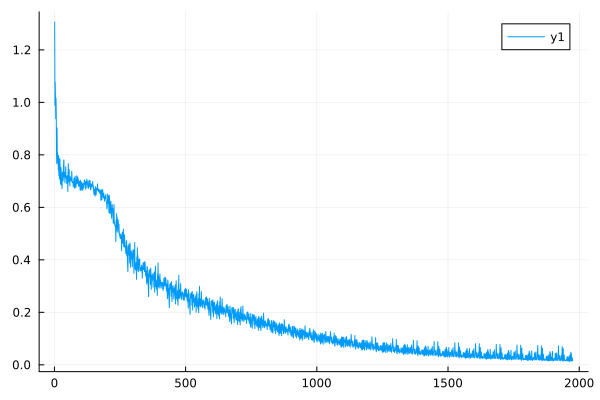

In [27]:
plot(losses)

In [28]:
yh1, _ = model(x0, pst, stt)

(Float32[0.027661053 0.027961552 … 0.029392984 0.0399939; 0.9723389 0.97203845 … 0.97060704 0.96000606], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (rng = Xoshiro(0xcfa08b14fbe490d2, 0x1cd3138b89e46d32, 0x1f592f22485609b7, 0xbe861015833ce9b2, 0xc90c4a0730db3f7e), training = Val{true}()), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple(), layer_7 = (rng = Xoshiro(0x6df5888af13c1452, 0xcc2ab7bd3a56f457, 0xf7eeb7fe69d69965, 0x1090144aa073c15b, 0xc90c4a0730db3f7e), training = Val{true}()), layer_8 = NamedTuple(), layer_9 = NamedTuple(), layer_10 = NamedTuple()))

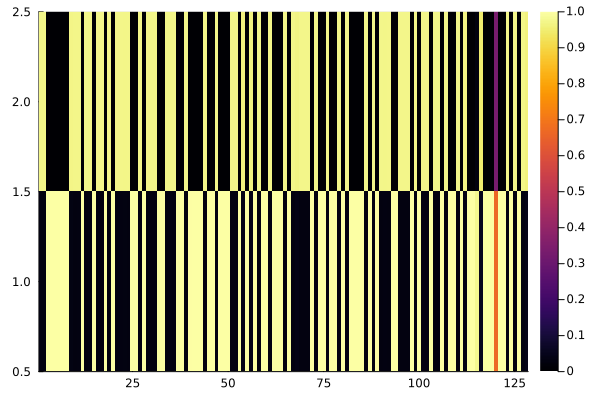

In [29]:
heatmap(yh1 |> cdev)

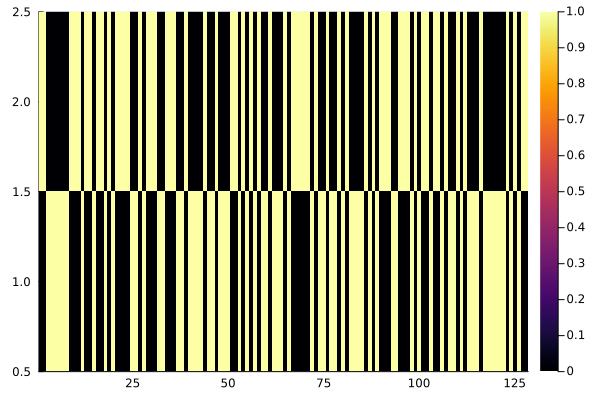

In [30]:
heatmap(y0 |> cdev)

In [31]:
test_loader = generate_dataset(rng, 1000, args)

8-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [32]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        true_labels = onecold(y)
        
        total_correct += sum(pred_labels .== true_labels)
        total_samples += size(x, 4)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [33]:
test(model, test_loader, pst, stt)

0.996

In [34]:
test(model, test_loader, ps, st)

0.484